In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


In [6]:
edge_crop = 32
patch_size = 25

num_images = 5000
num_patches = 5000

channel = 'LED119'
confidence_interval = 90
num_bootstrap_samples = 50

images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)


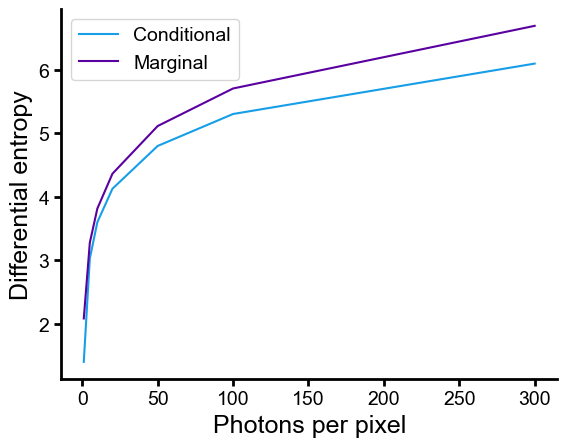

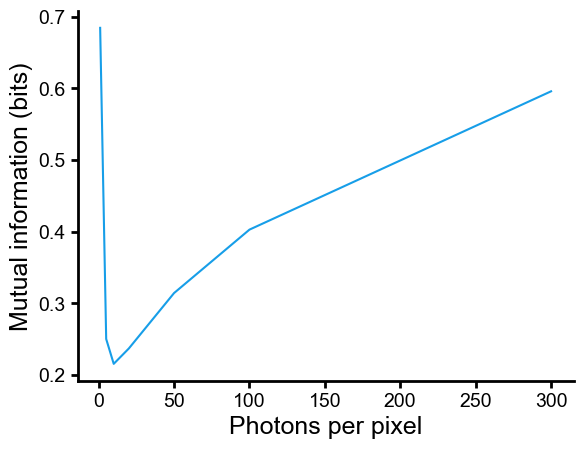

In [7]:
# photons_per_pixel_values = [0.01, 0.1, 0.5, 1, 2, 4, 10, 50]
photons_per_pixel_values = [1, 5, 10, 20, 50, 100, 300]
# photons_per_pixel_values = [10, 20, 50 , 100, 300]

conditionals = []
marginals = []
mi = []
for photons_per_pixel in photons_per_pixel_values:
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images), seed=123)
    noisy_patches + onp.random.normal(size=noisy_patches.shape) 
    # mi.append(estimate_mutual_information(noisy_images=noisy_patches, verbose=True))
    h_y_given_x = compute_conditional_entropy(noisy_patches) / np.log(2)
    h_y_gaussian = gaussian_entropy_estimate(noisy_patches, stationary=True, eigenvalue_floor=1, show_plot=False) / np.log(2)
    conditionals.append(h_y_given_x)
    marginals.append(h_y_gaussian)
    mi.append(h_y_gaussian - h_y_given_x)

# plot both
fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, conditionals, label='Conditional')
ax.plot(photons_per_pixel_values, marginals, label='Marginal')
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Differential entropy')
ax.legend()
clear_spines(ax)

fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, mi)
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Mutual information (bits)')
clear_spines(ax)

## Does using the non-stationary gaussian model rescue it? No

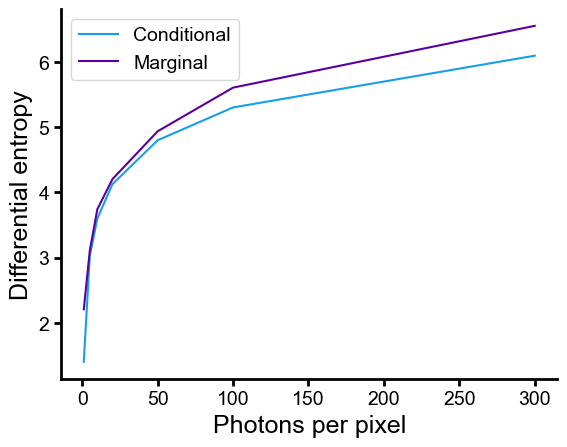

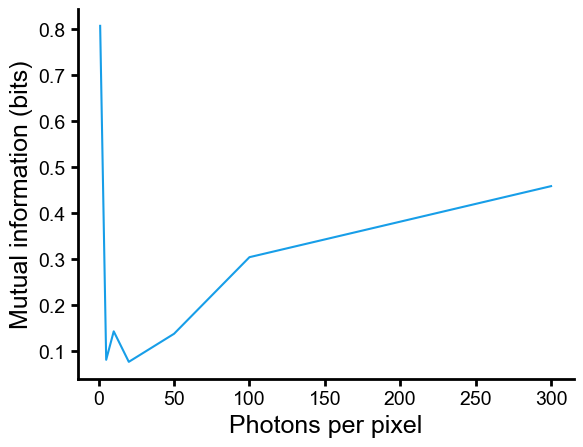

In [8]:
# photons_per_pixel_values = [0.01, 0.1, 0.5, 1, 2, 4, 10, 50]
photons_per_pixel_values = [1, 5, 10, 20, 50, 100, 300]
# photons_per_pixel_values = [10, 20, 50 , 100, 300]

conditionals = []
marginals = []
mi = []
for photons_per_pixel in photons_per_pixel_values:
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images), seed=123)
    noisy_patches + onp.random.normal(size=noisy_patches.shape) 
    # mi.append(estimate_mutual_information(noisy_images=noisy_patches, verbose=True))
    h_y_given_x = compute_conditional_entropy(noisy_patches) / np.log(2)
    h_y_gaussian = gaussian_entropy_estimate(noisy_patches, stationary=False, eigenvalue_floor=1, show_plot=False) / np.log(2)
    conditionals.append(h_y_given_x)
    marginals.append(h_y_gaussian)
    mi.append(h_y_gaussian - h_y_given_x)

# plot both
fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, conditionals, label='Conditional')
ax.plot(photons_per_pixel_values, marginals, label='Marginal')
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Differential entropy')
ax.legend()
clear_spines(ax)

fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, mi)
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Mutual information (bits)')
clear_spines(ax)